# Robust Regression: Steepest Descent vs. Newton's Method

Consider a simple linear regression problem,

$$
b_i = x_0 + a_i x_1 + \epsilon_i, \quad i = 1,\ldots,m,
$$

where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.
Follow the first lecture, we could form the optimization problem to try to obtain the intercept $x_0$ and slope $x_1$.


$$
\min_{x_0, x_1}~~ \frac{1}{2\sigma^2}\sum_{i=1}^m (b_i - x_0 - x_1a_i)^2 = \min_x \frac{1}{2\sigma^2}\|b-Ax\|^2,
$$

where,

$$
b = \begin{bmatrix}
b_1 \\
\vdots \\
b_m
\end{bmatrix}, \quad
A = \begin{bmatrix}
1 & a_1 \\
\vdots & \vdots \\
1 & a_m
\end{bmatrix}, \quad
x = \begin{bmatrix}
x_0 \\
x_1
\end{bmatrix}.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Create data

In [2]:
np.random.seed(345)
#
m = 10
n = 2
s1 = 0.5
s2 = 20.0
#
a = np.linspace(1.0, 10.0, m)
A = np.hstack((np.ones((m,1)), a.reshape(m,1)))
x = np.random.randn(2)
e = s1*np.random.randn(m)
e[-1] += s2                         # add an outlier 
#
b = A.dot(x) + e

Text(0.5, 1.0, 'linear regression data with outliers')

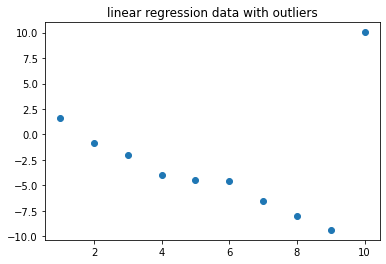

In [3]:
# plot the data
plt.plot(a, b, 'o')
plt.title('linear regression data with outliers')

### Linear regression

We have a closed form solution for the linear regression problem: taking the gradient and setting it equal to $0$, we get 

$$
A^\top A x = A^\top b
$$

We can solve this system of linear equations to get the solution $x^*$. Let's see how the solution behaves when we have an outlier. 

In [4]:
ATA = A.T.dot(A)
ATb = A.T.dot(b)
#
x_ls = np.linalg.solve(ATA, ATb)       # least squares solution
b_ls = A.dot(x_ls)                     # predicted data using the least squares solution

Text(0.5, 1.0, 'linear regression solution')

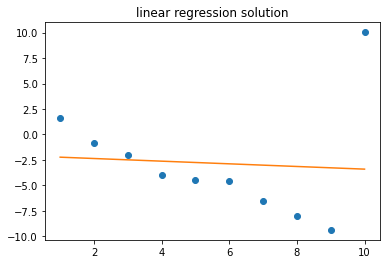

In [5]:
# plot the result
plt.plot(a, b, 'o')
plt.plot(a, b_ls)
plt.title('linear regression solution')

## Student's t penalty

In order to deal with outlier, we introduce [Student's t](https://en.wikipedia.org/wiki/Student%27s_t-distribution) penalty. The Student's t penalty generalizes the Cauchy distribution, as we will see below. 

* Gaussian (least square): $\frac{1}{2}r_i^2$

* Student's t: $\ln(1 + r_i^2/\nu)$

* Cauchy distribution: take $\nu=1$. 

Denote $r = A x - y$ as the residual. Using the Student's t penalty our optimization problem becomes,

$$
\min_x~~F(b - Ax):= \sum_{i=1}^m f(r_i) = \sum_{i=1}^m \ln(1 + r_i^2/\nu), \quad \text{s.t.}~~r = b-Ax.
$$

In [27]:
nu = 1.0
z = np.linspace(-4.5, 4.5, 401)
b_gaussian = 0.5*z**2
b_gaussian_influence = z                      # the `influence' is the derivative of the objective function
b_studentt = np.log(1.0 + z**2/nu)             
b_studentt_influence = (2*z/nu)/(1.0 + z**2/nu) #influence of student's t is *decreasing* like 1/z when z large

Text(0.5, 1.0, "Gaussian vs Student's t")

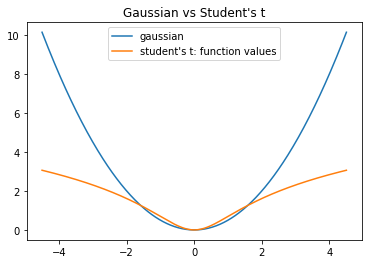

In [28]:
plt.plot(z, b_gaussian)
plt.plot(z, b_studentt)
plt.legend(['gaussian', 'student\'s t: function values'])
plt.title('Gaussian vs Student\'s t')

Text(0.5, 1.0, "Gaussian vs Student's t")

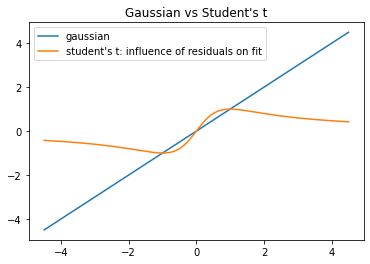

In [29]:
plt.plot(z, b_gaussian_influence)
plt.plot(z, b_studentt_influence)
plt.legend(['gaussian', 'student\'s t: influence of residuals on fit'])
plt.title('Gaussian vs Student\'s t')

## Gradient descent on Student's t regression

In contrast to the Gaussian regression, there is no closed form solution. We will come back to the optimization details later on; for now, we just focus on the big idea. The lines below compute a step length that ensures gradient descent will converge. We'll understand this soon enough. 


First we need to resolve the step size problem, is the objective $\beta$ smooth, or should we use line search?
Fortunately, it is $\beta$ smooth, to see this we calculate the gradient and Hessian of the stduent's t function.
$$
f'(r_i) = \frac{2 r_i}{\nu + r_i^2}, \quad f''(r_i) = \frac{2(\nu - r_i^2)}{(\nu + r_i^2)^2}.
$$
And we could see that,
$$
f''(r_i) \le \frac{2}{\nu}.
$$
From the chain rule we have,
$$
\nabla^2 F(Ax - y) = A^\top \nabla^2 F(r) A ~~\Rightarrow~~ \|\nabla^2 F(Ax - y)\| \le \frac{2}{\nu}\|A\|^2.
$$
and we could set $\beta = \frac{2}{\nu}\|A\|^2$.

In [52]:
# define all the functions
def stRFunc(r):
    return np.sum(np.log(1.0 + r**2/nu))
#
def stRGrad(r):
    return 2.0*r/(nu + r**2)
#
def stRHess(r):
#    return 2.0*(nu - r**2)/(nu + r**2)**2  #(true hessian)
    return 2.0/(nu + r**2)   # (my hessian approximation)

def stFunc(x):
    r = A.dot(x)-b 
    return stRFunc(r)
#
def stGrad(x):
    r = A.dot(x)-b
    return A.T.dot(stRGrad(r))
#
def stHess(x):
    r = A.dot(x)-b
    return A.T.dot(np.diag(stRHess(r)).dot(A))

In [53]:
# gradient descent
beta = 2.0/nu*np.linalg.norm(A)**2

# initial guess
x_st_gd = np.zeros(n)
g_st_gd = stGrad(x_st_gd)

tol = 1e-6
max_iter = 5000
print_per_iter = 200

err = np.linalg.norm(g_st_gd)
iter_count = 0


while err >= tol:
    # gradient step
    x_st_gd = x_st_gd - 1.0/beta*g_st_gd
    #
    g_st_gd = stGrad(x_st_gd)
    err = np.linalg.norm(g_st_gd)
    obj = stFunc(x_st_gd)
    #
    iter_count += 1
    if iter_count % print_per_iter == 0:
        print('iter %5d, obj %8.2e, err %8.2e' % (iter_count, obj, err))
    #
    if iter_count >= max_iter:
        break

iter   200, obj 6.58e+00, err 2.58e+00
iter   400, obj 5.32e+00, err 1.77e+00
iter   600, obj 4.87e+00, err 9.04e-01
iter   800, obj 4.77e+00, err 3.99e-01
iter  1000, obj 4.75e+00, err 1.67e-01
iter  1200, obj 4.74e+00, err 6.94e-02
iter  1400, obj 4.74e+00, err 2.86e-02
iter  1600, obj 4.74e+00, err 1.18e-02
iter  1800, obj 4.74e+00, err 4.84e-03
iter  2000, obj 4.74e+00, err 1.99e-03
iter  2200, obj 4.74e+00, err 8.18e-04
iter  2400, obj 4.74e+00, err 3.36e-04
iter  2600, obj 4.74e+00, err 1.38e-04
iter  2800, obj 4.74e+00, err 5.68e-05
iter  3000, obj 4.74e+00, err 2.33e-05
iter  3200, obj 4.74e+00, err 9.59e-06
iter  3400, obj 4.74e+00, err 3.94e-06
iter  3600, obj 4.74e+00, err 1.62e-06


## Newton's method on Student's t regression

Newton's method converges much faster.

In [54]:
# Newton's method

# initial guess
x_st_nt = np.zeros(n)

g_st_nt = stGrad(x_st_nt)
h_st_nt = stHess(x_st_nt)

tol = 1e-6
max_iter = 1000
print_per_iter = 1

err = np.linalg.norm(g_st_nt)
iter_count = 0

while err >= tol:
    # newton's step
    x_st_nt = x_st_nt - np.linalg.solve(h_st_nt, g_st_nt)
    #
    g_st_nt = stGrad(x_st_nt)
    h_st_nt = stHess(x_st_nt)
    err = np.linalg.norm(g_st_nt)
    obj = stFunc(x_st_nt)
    #
    iter_count += 1
    if iter_count % print_per_iter == 0:
        print('iter %5d, obj %8.2e, err %8.2e' % (iter_count, obj, err))
    #
    if iter_count >= max_iter:
        break

iter     1, obj 2.21e+01, err 8.40e+00
iter     2, obj 2.15e+01, err 7.05e+00
iter     3, obj 2.11e+01, err 7.35e+00
iter     4, obj 2.06e+01, err 9.35e+00
iter     5, obj 1.93e+01, err 1.37e+01
iter     6, obj 1.49e+01, err 2.32e+01
iter     7, obj 6.02e+00, err 2.64e+01
iter     8, obj 4.75e+00, err 1.65e+00
iter     9, obj 4.74e+00, err 3.69e-02
iter    10, obj 4.74e+00, err 7.34e-04
iter    11, obj 4.74e+00, err 1.34e-05
iter    12, obj 4.74e+00, err 2.41e-07


# What went wrong?

Newton's method certainly minimized the gradient, but it did so by pushing out $x$ to be HUGE which is not helpful at all, and did not decrease the objective.

Newton's method is not guaranteed to converge, but we can do a tweak in our algorithm to make sure it actually converges. The tweak is essentially replacing Newton's method with Gauss-Newton's Method. 



In [55]:
x_st_nt

array([ 1.54453955, -1.16183011])

## Result comparison

Now let's compare results

In [56]:
diff_gd_nt = np.linalg.norm(x_st_gd - x_st_nt)
if diff_gd_nt < 1e-6:
    print('Gradient descent and Newton\'s method reach the same solution')
    x_st = x_st_gd
else:
    print('Oops... something might be wrong with gradient descent or Newton\'s method' )

Gradient descent and Newton's method reach the same solution


In [57]:
b_st = A.dot(x_st_nt)

Text(0.5, 1.0, "linear vs. student's t")

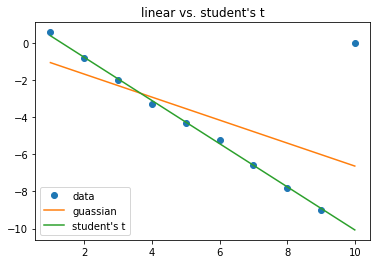

In [58]:
plt.plot(a, b, 'o')
plt.plot(a, b_ls)
plt.plot(a, b_st)
plt.legend(['data','guassian', 'student\'s t'])
plt.title('linear vs. student\'s t')